In [1]:
import sys
import numpy as np
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import os
import copy
import string
char_list = list(" '" + string.ascii_lowercase + '12 ')

def absmax(nd_array):
    a = np.max(np.abs(nd_array))
    return((-a,a))

def elapsed_time(t_start,unit):
    t_end = time.time()
    d = t_end - t_start
    if(unit=='min'):
        d /= 60
    elif(unit=='h'):
        d /= 3600
    print('%.2f '%d, unit + ' elapsed',sep='')

In [2]:
data_dir = "/data/asr_introspection/"
input_dir = data_dir + "spectrogram_input/"
input_groupmappings = os.listdir(input_dir)
input_groupmappings = [s for s in input_groupmappings if "group" in s]

act_dir = data_dir + "activations/"
grad_dir = data_dir + "gradients/"

n_channels = [128,256,256,256,256,256,256,256,256,256,2048,2048,31]
layer_ranges = [206,80,74,68,62,56,50,44,38,32,1,1,1]

with open(data_dir + "vocabularies.pkl", "rb") as input_file:
    graphemes_list, phonemes_list, _ = pickle.load(input_file)
joint_list = graphemes_list + phonemes_list

In [ ]:
averages = list()
n_samples = np.repeat(0,len(joint_list))
for i in range(len(layer_ranges)-1):
    contents = {'acts': np.zeros((len(joint_list),n_channels[i],layer_ranges[i])),
                'grads': np.zeros((len(joint_list),n_channels[i],layer_ranges[i]))}
    averages.append(contents)

t_start = time.time()
for f_id, f in enumerate(input_groupmappings[1]):
    spectrogram = np.load(input_dir + f[:-17] + ".npy")
    index = int((spectrogram.shape[1]-206)/2) -1
    if os.path.isfile(grad_dir+f[:-17]+"_grads_pos"+str(index).zfill(4)+".pkl"):
        groupmapping = np.load(input_dir + f)
        gm_index = 0

        with open(act_dir+f[:-17]+"_act.pkl", "rb") as input_file:
            forward_act = pickle.load(input_file)

        # go through all positions
        for index in groupmapping[:-1,0]:
#         for index in range(int((spectrogram.shape[1]-206)/2)):
            snippet = spectrogram[:,index*2:index*2+206]
            snippet_act = copy.deepcopy(forward_act)
            for i in range(len(forward_act)):
                snippet_act[i] = np.transpose(forward_act[i][0,index:index+layer_ranges[i+1],:])
            
            with open(grad_dir+f[:-17]+"_grads_pos"+str(index).zfill(4)+".pkl", "rb") as input_file:
                grads = pickle.load(input_file)
                for i in range(len(grads)):
                    grads[i] = np.abs(np.transpose(grads[i]))
                
            #ALIGNMENT
            for i in range(len(grads)-2):
                frame_width = grads[i].shape[1]
                
                to_align_on = np.abs(grads[i])
                # option: weight abs gradients by activation strength
                # rationale -> align on high activations, which are important for the predicted letter
                #              only for activations, makes no sense for input (high input value != strong activation)
                if(i>0):
                    to_align_on = to_align_on * snippet_act[i-1]                
                
                # find time step of highest absolute gradient 
                center_index = np.argmax(np.max(to_align_on,0))
                
                
                shift = int(center_index - (frame_width/2))
                if(shift<0):
                    idx_from, idx_to = [0,frame_width+2*shift]
                elif(shift>0):
                    idx_from, idx_to = [2*shift,frame_width]
                else:
                    idx_from, idx_to = [0,frame_width]
                shift = np.abs(shift)
                
                if(i==0):
                    #align input
                    centered_frame = snippet[:,idx_from:idx_to]
                    snippet = np.zeros_like(snippet)
                    snippet[:,shift:snippet.shape[1]-shift] = centered_frame
                else:
                    #align activations
                    centered_frame = snippet_act[i-1][:,idx_from:idx_to]
                    snippet_act[i-1] = np.zeros_like(snippet_act[i-1])
                    snippet_act[i-1][:,shift:snippet_act[i-1].shape[1]-shift] = centered_frame
                    
                # align gradients
                centered_frame = grads[i][:,idx_from:idx_to]
                grads[i] = np.zeros_like(grads[i])
                grads[i][:,shift:grads[i].shape[1]-shift] = centered_frame
            
            #AVERAGING over graphemes and phonemes
            grapheme_index = -1
            phoneme_index = -1
            if(index in groupmapping[:,0]):
                #this is where graphemes or phonemes are
                grapheme_index = joint_list.index(groupmapping[gm_index,1])
                phoneme = groupmapping[gm_index,2]
                if(phoneme != " "):
                    phoneme_index = joint_list.index(phoneme)
                gm_index = gm_index + 1
            else:
                #this is a blank label example (or repetition character)
                grapheme_index = joint_list.index(" ")
            
            for i in range(len(grads)):
                if(i==0):
                    #input
                    averages[i]['acts'][grapheme_index,:,:] += snippet
                    n_samples[grapheme_index] += 1
                    if(phoneme_index>=0):
                        averages[i]['acts'][phoneme_index,:,:] += snippet
                        n_samples[phoneme_index] += 1
                else:
                    #activations
                    averages[i]['acts'][grapheme_index,:,:] += snippet_act[i-1]
                    if(phoneme_index>=0):
                        averages[i]['acts'][phoneme_index,:,:] += snippet_act[i-1]
                averages[i]['grads'][grapheme_index,:,:] += grads[i]
                if(phoneme_index>=0):
                    averages[i]['grads'][phoneme_index,:,:] += grads[i]
                if(np.any(averages[i]['acts']>1e20) or np.any(averages[i]['grads']>1e20)):
                    raise ValueError('accumulated sums are getting too large. (max: '+str(int(np.max(averages[i]['acts'])))+')')
                    
            
    
    if((f_id+1) % 50==0):
        print("finished " + str(f_id+1), end=" - ")
        elapsed_time(t_start,"min")
        
# with open(data_dir + 'summation_abs_actxgrad_all_noblank.pkl', 'wb') as f:
#     pickle.dump([averages,n_samples], f, pickle.HIGHEST_PROTOCOL)

finished 50 - 2.04 min elapsed
finished 100 - 3.27 min elapsed
finished 150 - 5.15 min elapsed
finished 200 - 7.29 min elapsed
finished 250 - 9.08 min elapsed
finished 300 - 10.67 min elapsed
finished 350 - 12.10 min elapsed
finished 400 - 13.84 min elapsed
finished 450 - 15.49 min elapsed
finished 500 - 17.54 min elapsed
finished 550 - 19.42 min elapsed
finished 600 - 21.20 min elapsed
finished 650 - 23.20 min elapsed
finished 700 - 24.50 min elapsed
finished 750 - 26.18 min elapsed
finished 800 - 28.28 min elapsed
finished 850 - 30.36 min elapsed
finished 900 - 32.14 min elapsed
finished 950 - 33.96 min elapsed
finished 1000 - 35.53 min elapsed
finished 1050 - 37.98 min elapsed
finished 1100 - 40.07 min elapsed
finished 1150 - 42.68 min elapsed
finished 1200 - 46.20 min elapsed
finished 1250 - 49.06 min elapsed
finished 1300 - 51.73 min elapsed
finished 1350 - 54.27 min elapsed
finished 1400 - 56.89 min elapsed
finished 1450 - 59.53 min elapsed
finished 1500 - 62.39 min elapsed
finis

In [288]:
joint_list[:27]

["'",
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

' 11


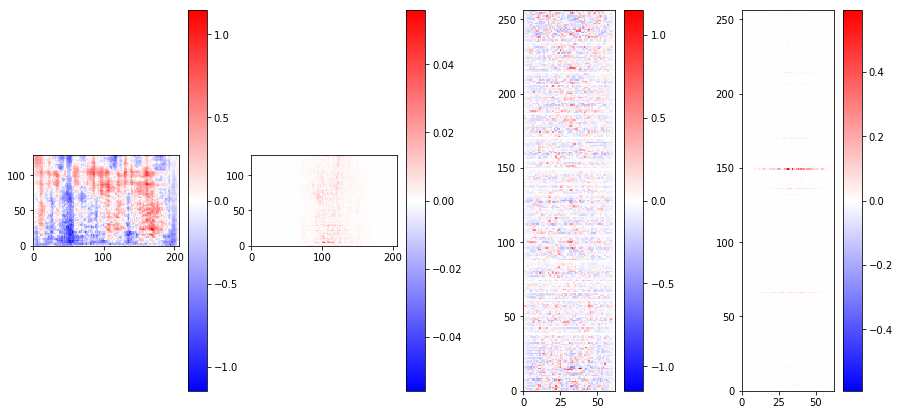

a 330


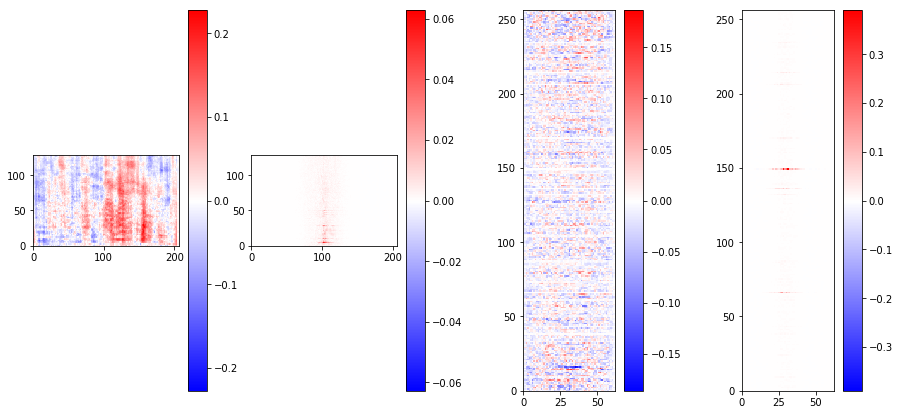

b 63


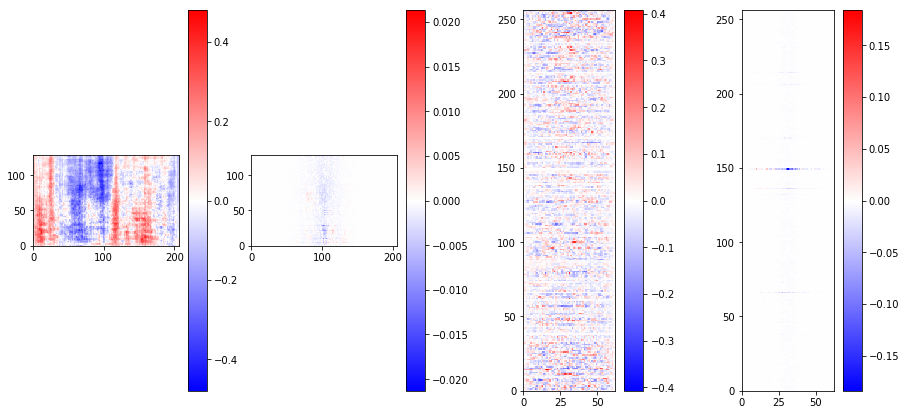

c 161


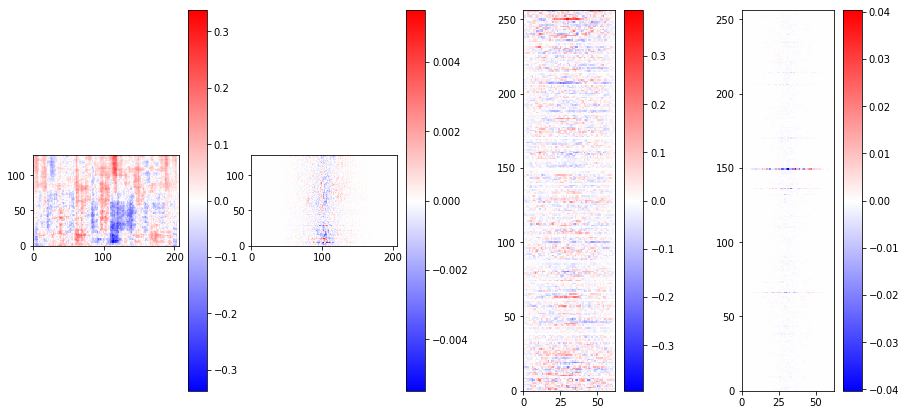

d 193


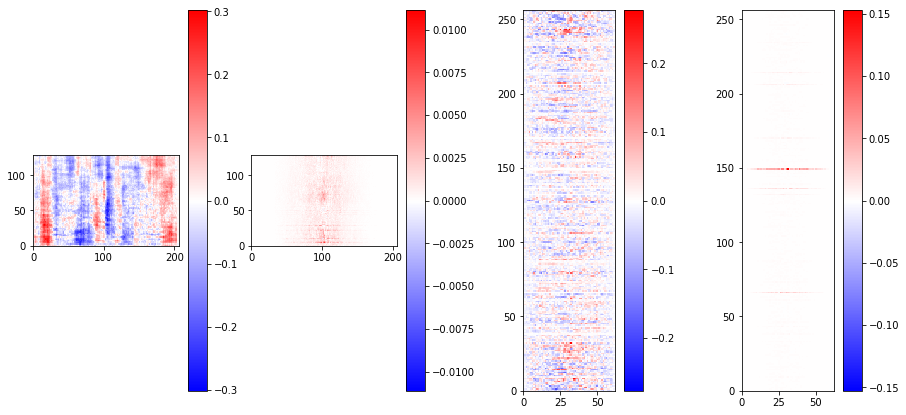

e 546


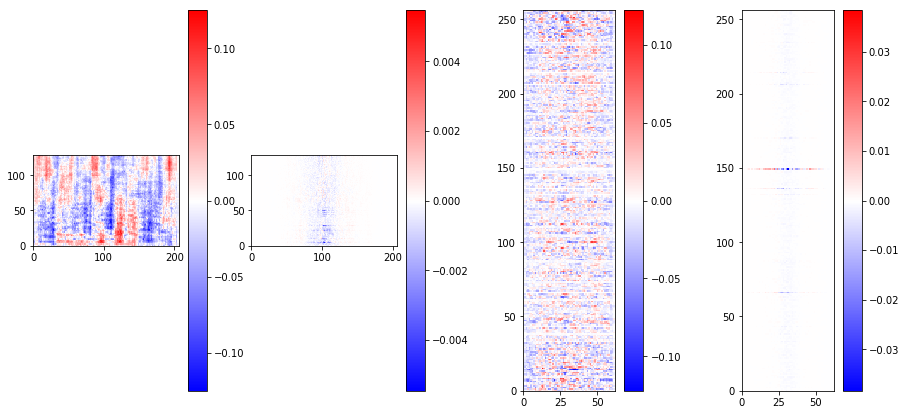

f 127


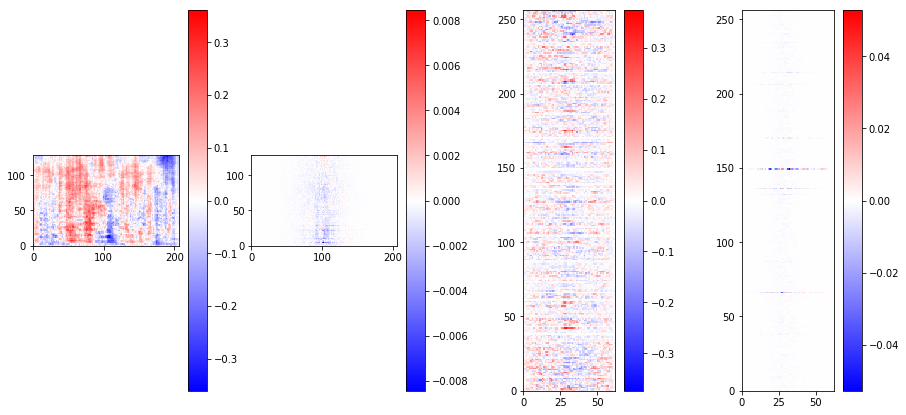

g 112


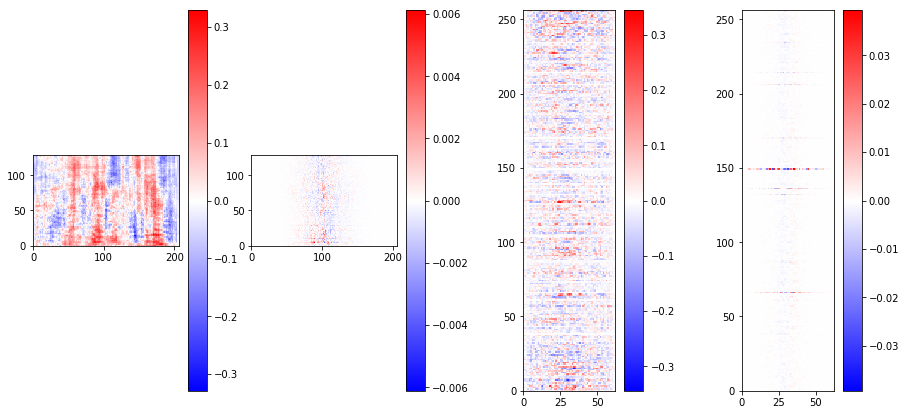

h 291


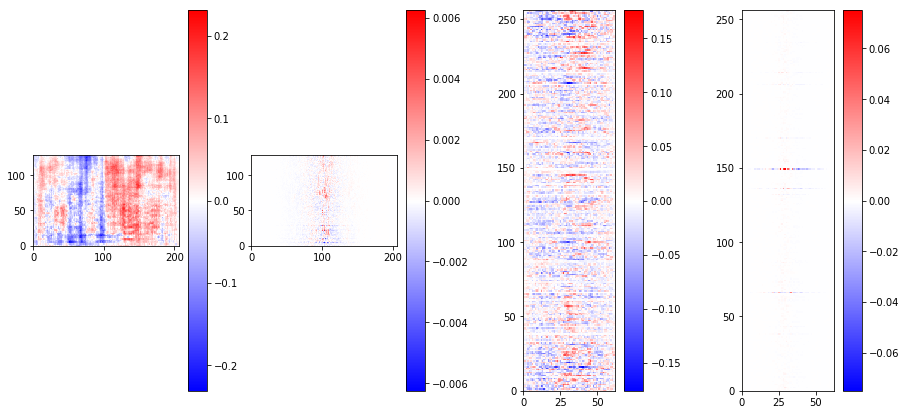

i 332


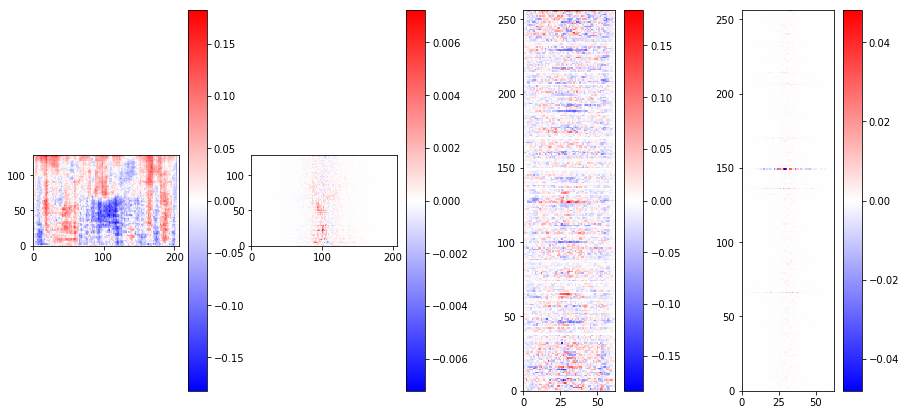

j 4


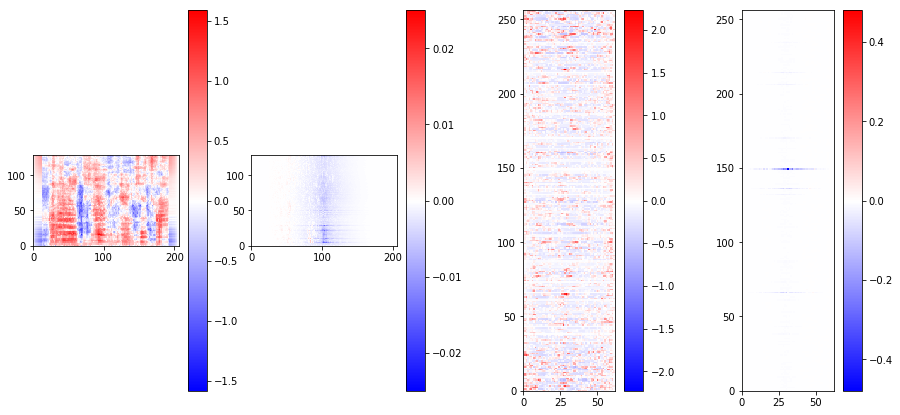

k 32


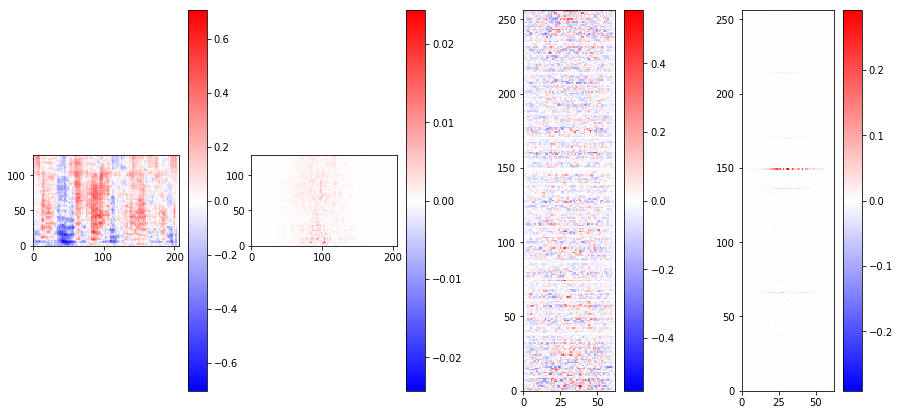

l 228


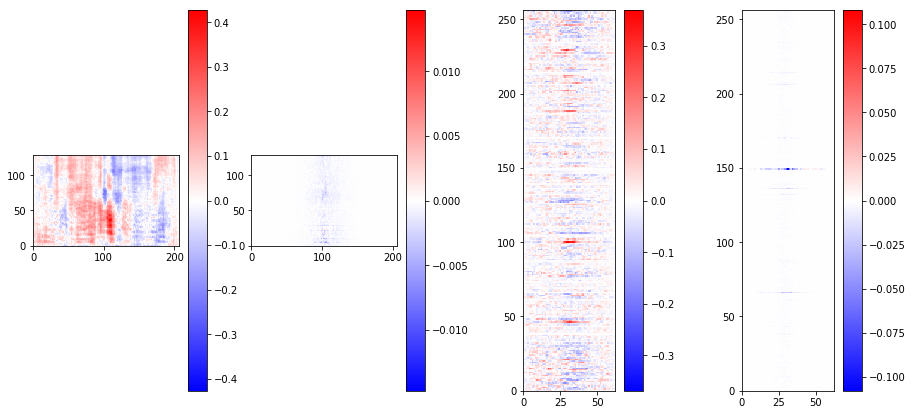

m 142


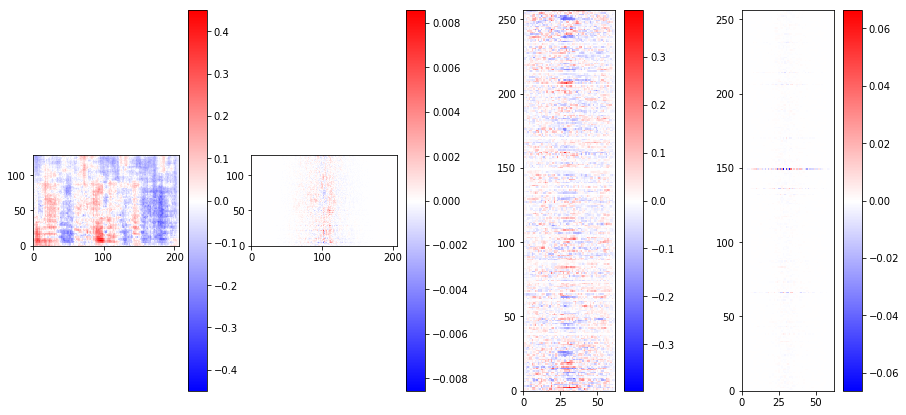

n 451


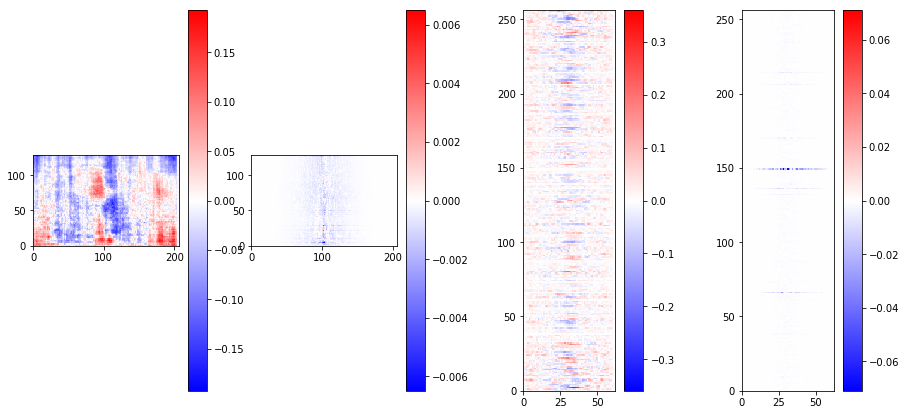

o 326


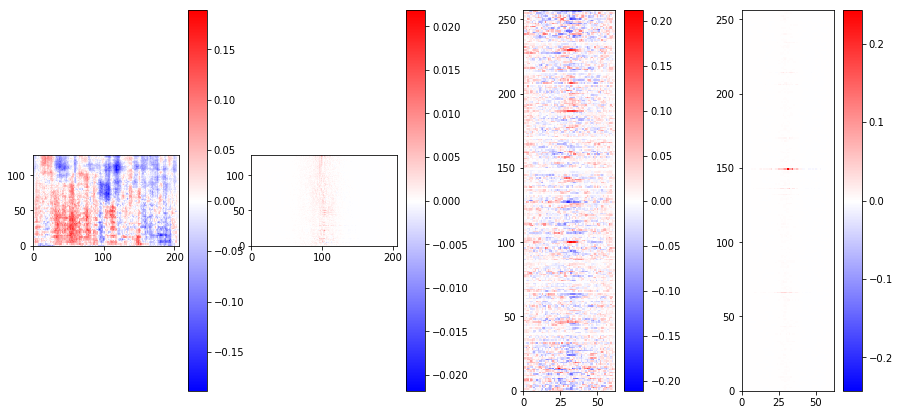

p 102


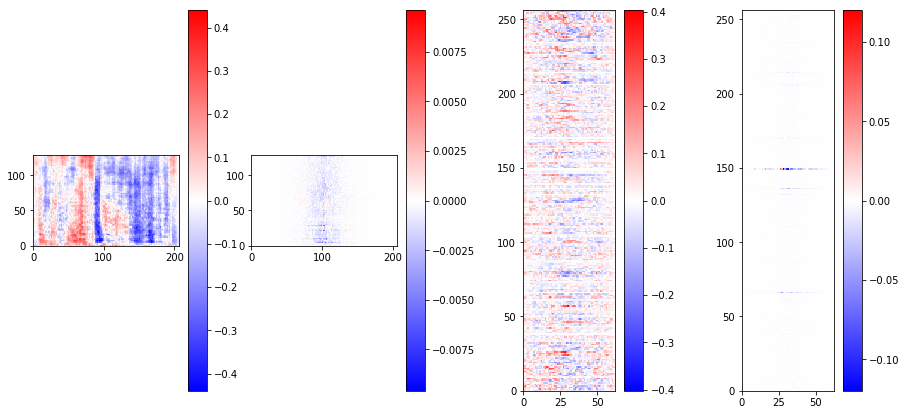

q 7


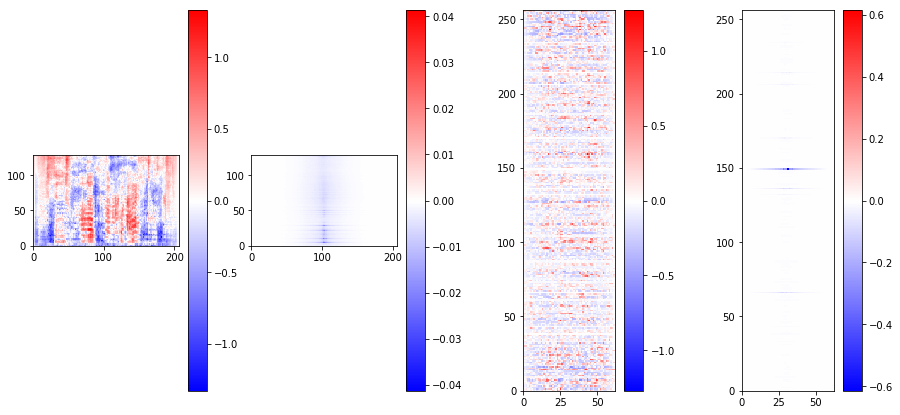

r 336


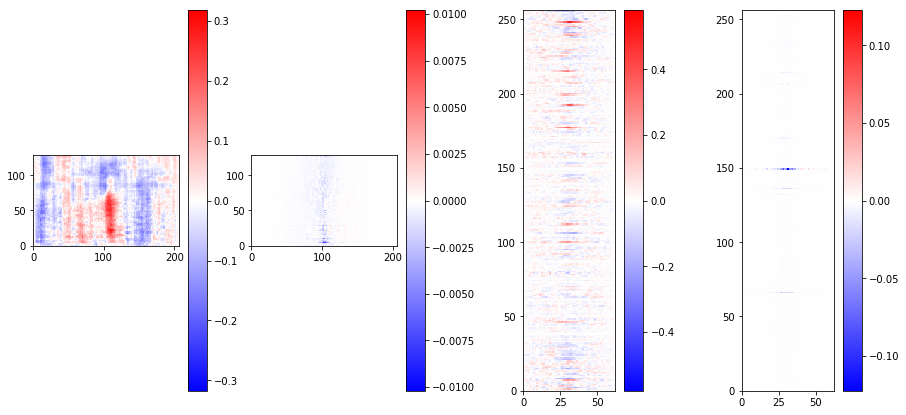

s 371


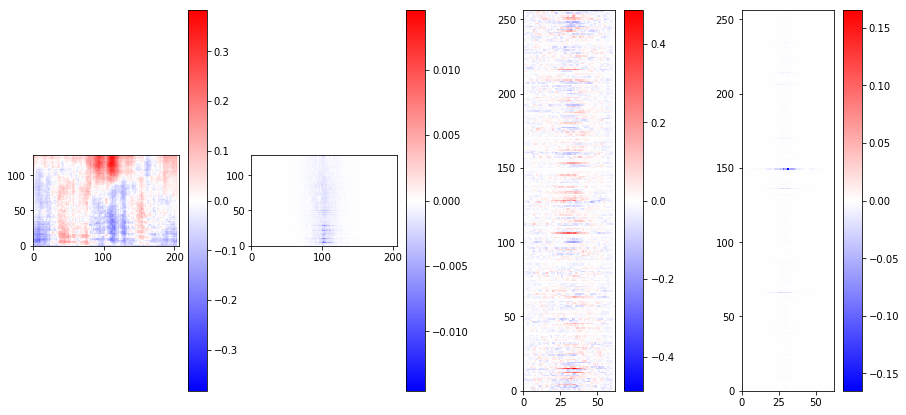

t 463


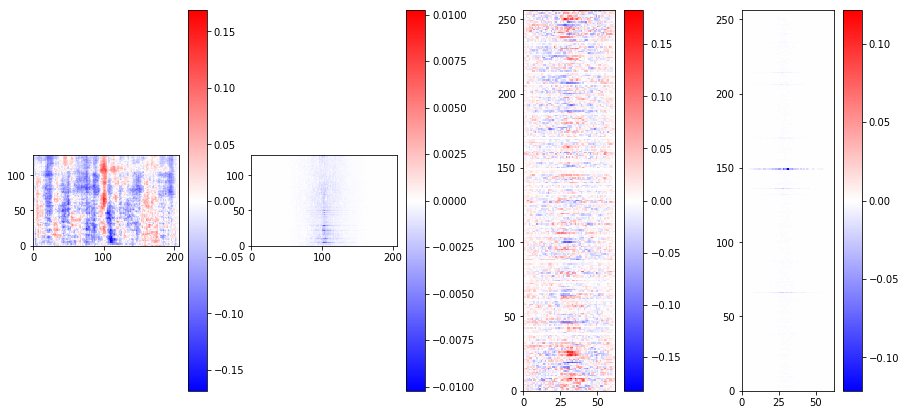

u 133


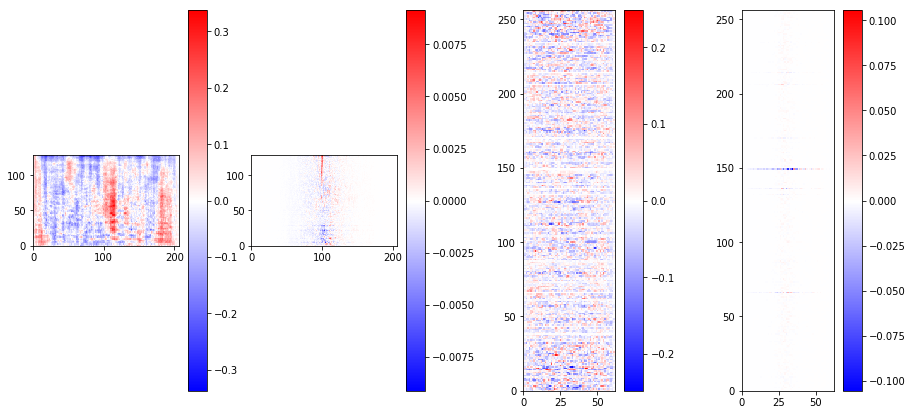

v 52


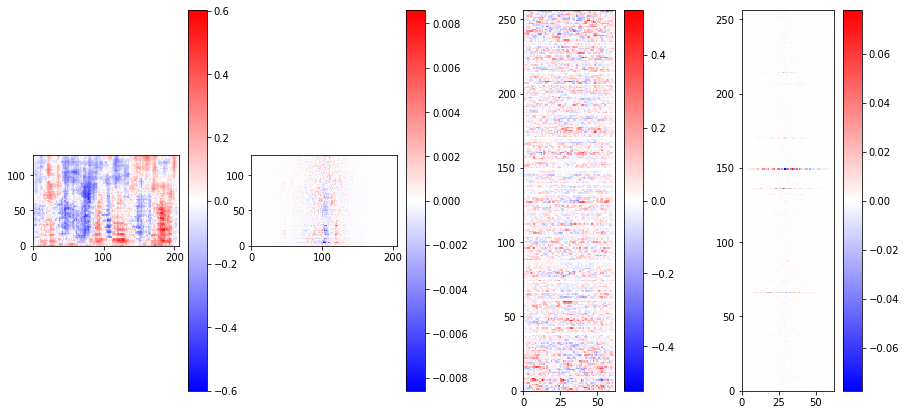

w 94


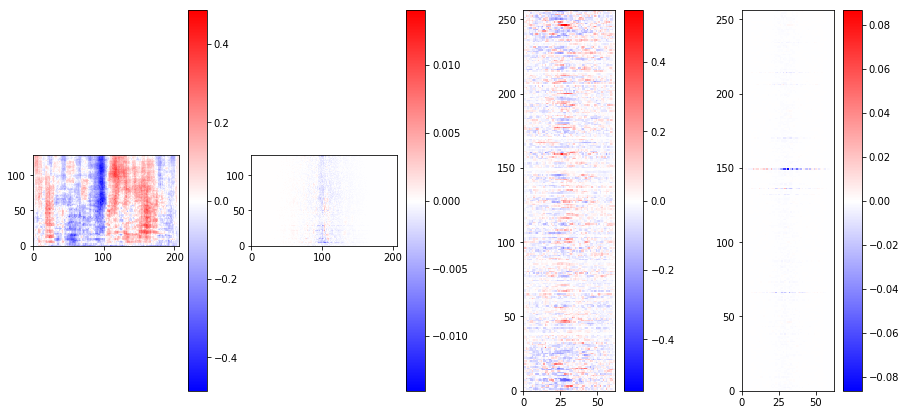

x 24


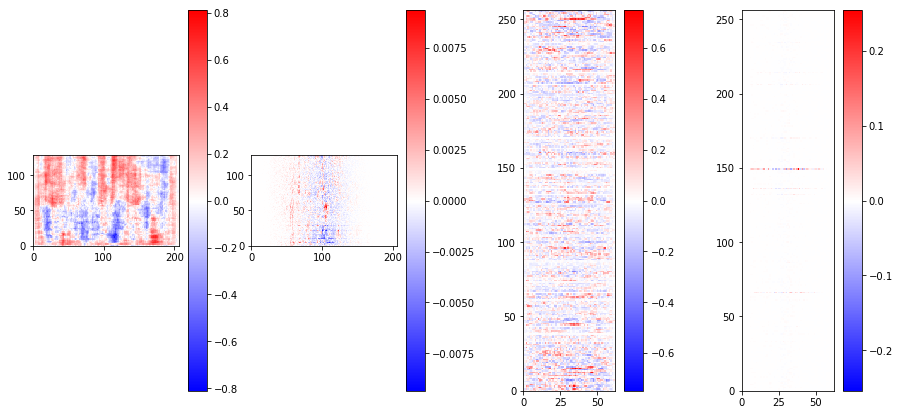

y 82


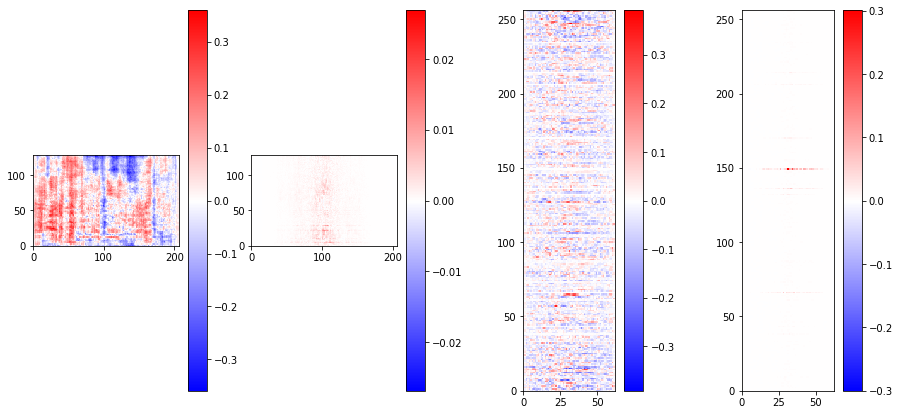

z 0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


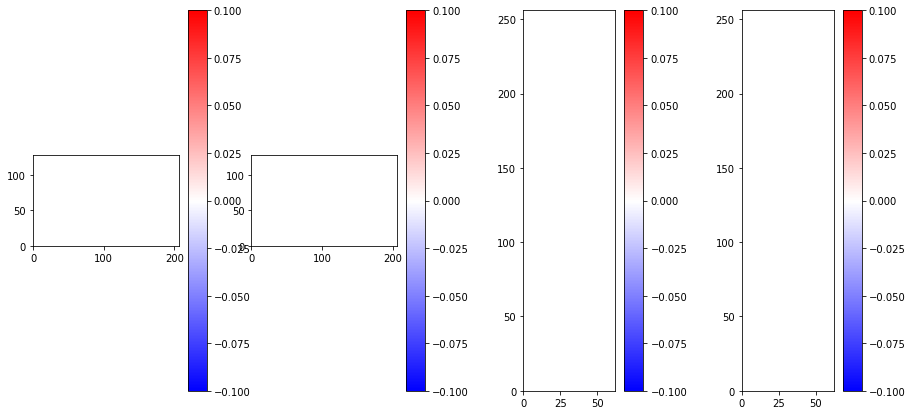

In [344]:
for char_id in range(27):
    print(joint_list[char_id],n_samples[char_id])
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,7))

    heatmap_matrix = averages[0]['acts'][char_id,:,:]/n_samples[char_id] - np.sum(averages[0]['acts'][:27,:,:],0)/np.sum(n_samples[:27])
    heatmap = axes[0].pcolor(heatmap_matrix, cmap=plt.cm.bwr)
    axes[0].set_aspect(1)
    fig.colorbar(heatmap,ax=axes[0])
    heatmap.set_clim(absmax(heatmap_matrix))
    
    heatmap_matrix = averages[0]['grads'][char_id,:,:]/n_samples[char_id] - np.sum(averages[0]['grads'][:27,:,:],0)/np.sum(n_samples[:27]) 
    heatmap = axes[1].pcolor(heatmap_matrix, cmap=plt.cm.bwr)
    axes[1].set_aspect(1)
    fig.colorbar(heatmap,ax=axes[1])
    heatmap.set_clim(absmax(heatmap_matrix))
    
    heatmap_matrix = averages[4]['acts'][char_id,:,:]/n_samples[char_id] - np.sum(averages[4]['acts'][:27,:,:],0)/np.sum(n_samples[:27])
    heatmap = axes[2].pcolor(heatmap_matrix, cmap=plt.cm.bwr)
    axes[2].set_aspect(1)
    fig.colorbar(heatmap,ax=axes[2])
    heatmap.set_clim(absmax(heatmap_matrix))
    
    heatmap_matrix = averages[4]['grads'][char_id,:,:]/n_samples[char_id] - np.sum(averages[4]['grads'][:27,:,:],0)/np.sum(n_samples[:27]) 
    heatmap = axes[3].pcolor(heatmap_matrix, cmap=plt.cm.bwr)
    axes[3].set_aspect(1)
    fig.colorbar(heatmap,ax=axes[3])
    heatmap.set_clim(absmax(heatmap_matrix))

    plt.show()

In [355]:
joint_list.index('t')

20

In [6]:
modes = ["only average", "normalizer", "average - normalizer", "average - normalizer, avg.grad*avg.act"]

for char_id in [1,20]:
    print(joint_list[char_id] + " - " + str(n_samples[char_id] + "samples"))
    for m in [2,3]:
        print(modes[m])
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,7))

        for ax_id in range(4):
            if(ax_id==0 or ax_id==2):
                value_set = 'acts'
            else:
                value_set = 'grads'
            if(ax_id<=1):
                layer_id = 0
            else:
                layer_id = 4

            if(m==0):
                # only average
                heatmap_matrix = averages[layer_id][value_set][char_id,:,:]/n_samples[char_id]
            elif(m==1):
                # normalizer
                heatmap_matrix = np.sum(averages[layer_id][value_set][:27,:,:],0)/np.sum(n_samples[:27])
            elif(m==2):
                # average - normalizer
                heatmap_matrix = averages[layer_id][value_set][char_id,:,:]/n_samples[char_id] - np.sum(averages[layer_id][value_set][:27,:,:],0)/np.sum(n_samples[:27])
            else:
                # average - normalizer, avg.grad*avg.act
                heatmap_matrix = averages[layer_id][value_set][char_id,:,:]/n_samples[char_id] - np.sum(averages[layer_id][value_set][:27,:,:],0)/np.sum(n_samples[:27])
                if(value_set == 'grads'):
                    avg_acts = averages[layer_id]['acts'][char_id,:,:]/n_samples[char_id] - np.sum(averages[layer_id]['acts'][:27,:,:],0)/np.sum(n_samples[:27])
                    heatmap_matrix = heatmap_matrix * avg_acts
            heatmap = axes[ax_id].pcolor(heatmap_matrix, cmap=plt.cm.bwr)
            axes[ax_id].set_aspect(1)
            fig.colorbar(heatmap,ax=axes[ax_id])
            heatmap.set_clim(absmax(heatmap_matrix))

        plt.show()    


TypeError: ufunc 'add' did not contain a loop with signature matching types dtype('<U21') dtype('<U21') dtype('<U21')

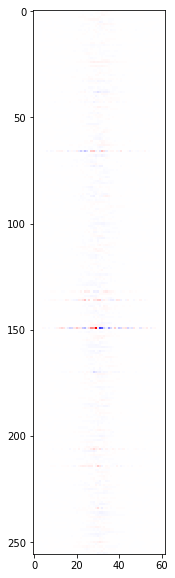

In [308]:
plt.figure(figsize=(5,10))
plt.imshow(averages[4]['grads'][20,:,:],cmap='bwr')
plt.clim(absmax(averages[4]['grads'][20,:,:]))
plt.show()

In [196]:
for f_id, f in enumerate(input_groupmappings[:1]):
    spectrogram = np.load(input_dir + f[:-17] + ".npy")
    index = int((spectrogram.shape[1]-206)/2) -1
    if os.path.isfile(grad_dir+f[:-17]+"_grads_pos"+str(index).zfill(4)+".pkl"):
        groupmapping = np.load(input_dir + f)
        gm_index = 0

        with open(act_dir+f[:-17]+"_act.pkl", "rb") as input_file:
            forward_act = pickle.load(input_file)

        # go through all positions
        for index in range(int((spectrogram.shape[1]-206)/2)):
            snippet = spectrogram[:,index*2:index*2+206]
            snippet_act = copy.deepcopy(forward_act)
            for i in range(len(forward_act)):
                snippet_act[i] = forward_act[i][0,index:index+layer_ranges[i+1],:]
            
            with open(grad_dir+f[:-17]+"_grads_pos"+str(index).zfill(4)+".pkl", "rb") as input_file:
                grads = pickle.load(input_file)

In [197]:
groupmapping

array([[4, 'f', 'F', 'F'],
       [6, 'o', 'AA', 'AA1'],
       [10, 't', 'T', 'T'],
       [11, 't', 'IY', 'IY1'],
       [16, 't', 'IY', 'IY1'],
       [18, 'u', ' ', ' '],
       [26, 't', 'TH', 'TH'],
       [27, 'h', 'TH', 'TH'],
       [28, 'a', 'AE', 'AE1'],
       [33, 'n', 'NG', 'NG'],
       [34, 'k', ' ', ' '],
       [35, 'k', 'K', 'K'],
       [37, 'd', ' ', ' '],
       [43, 'm', 'M', 'M'],
       [45, 'e', 'EH', 'EH1'],
       [70, 'o', 'OW', 'OW1'],
       [73, 'v', ' ', ' '],
       [74, 'v', 'V', 'V'],
       [76, 'e', ' ', ' '],
       [77, 'e', 'ER', 'ER0'],
       [78, 'r', ' ', ' '],
       [79, 'r', 'ER', 'ER0'],
       [85, 'w', 'HH', 'HH'],
       [86, 'h', 'HH', 'HH'],
       [87, 'e', 'W', 'W'],
       [89, 'l', ' ', ' '],
       [90, 'l', ' ', ' '],
       [91, 'l', 'L', 'L'],
       [93, 'm', ' ', ' '],
       [94, 'm', ' ', ' '],
       [95, 'm', 'M', 'M'],
       [97, 'i', 'IH', 'IH0'],
       [98, 'n', ' ', ' '],
       [99, 'n', 'NG', 'NG'],
       [100

In [203]:
with open(grad_dir+f[:-17]+"_grads_pos"+str(10).zfill(4)+".pkl", "rb") as input_file:
    grads1 = pickle.load(input_file)
with open(grad_dir+f[:-17]+"_grads_pos"+str(11).zfill(4)+".pkl", "rb") as input_file:
    grads2 = pickle.load(input_file)

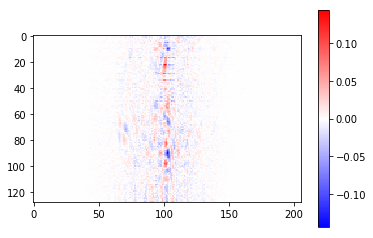

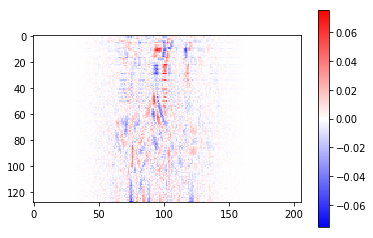

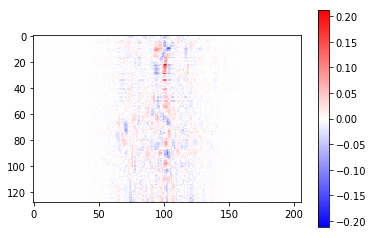

In [204]:
plt.imshow(np.transpose(grads1[0]),cmap='bwr')
plt.clim(absmax(grads1[0]))
plt.colorbar()
plt.show()
plt.imshow(np.transpose(grads2[0]),cmap='bwr')
plt.clim(absmax(grads2[0]))
plt.colorbar()
plt.show()
plt.imshow(np.transpose(grads2[0]+grads1[0]),cmap='bwr')
plt.clim(absmax(grads2[0]+grads1[0]))
plt.colorbar()
plt.show()

In [173]:
groupmapping

array([[4, 'f', 'F', 'F'],
       [6, 'o', 'AA', 'AA1'],
       [10, 't', 'T', 'T'],
       [11, 't', 'IY', 'IY1'],
       [16, 't', 'IY', 'IY1'],
       [18, 'u', ' ', ' '],
       [26, 't', 'TH', 'TH'],
       [27, 'h', 'TH', 'TH'],
       [28, 'a', 'AE', 'AE1'],
       [33, 'n', 'NG', 'NG'],
       [34, 'k', ' ', ' '],
       [35, 'k', 'K', 'K'],
       [37, 'd', ' ', ' '],
       [43, 'm', 'M', 'M'],
       [45, 'e', 'EH', 'EH1'],
       [70, 'o', 'OW', 'OW1'],
       [73, 'v', ' ', ' '],
       [74, 'v', 'V', 'V'],
       [76, 'e', ' ', ' '],
       [77, 'e', 'ER', 'ER0'],
       [78, 'r', ' ', ' '],
       [79, 'r', 'ER', 'ER0'],
       [85, 'w', 'HH', 'HH'],
       [86, 'h', 'HH', 'HH'],
       [87, 'e', 'W', 'W'],
       [89, 'l', ' ', ' '],
       [90, 'l', ' ', ' '],
       [91, 'l', 'L', 'L'],
       [93, 'm', ' ', ' '],
       [94, 'm', ' ', ' '],
       [95, 'm', 'M', 'M'],
       [97, 'i', 'IH', 'IH0'],
       [98, 'n', ' ', ' '],
       [99, 'n', 'NG', 'NG'],
       [100

In [91]:
for i in grads:
    print(i.shape)

(206, 128)
(74, 256)
(68, 256)
(62, 256)
(56, 256)
(50, 256)
(44, 256)
(38, 256)
(32, 256)
(1, 2048)
(1, 2048)


In [67]:
for i in aligned_averages:
    print(i.shape)

(128, 206)
(256, 80)
(256, 74)
(256, 68)
(256, 62)
(256, 56)
(256, 50)
(256, 44)
(256, 38)
(256, 32)
(2048, 1)
(2048, 1)


In [43]:
for i in range(len(forward_act)):
    print(snippet_act[i].shape)

(80, 256)
(74, 256)
(68, 256)
(62, 256)
(56, 256)
(50, 256)
(44, 256)
(38, 256)
(32, 256)
(1, 2048)
(1, 2048)
(1, 31)


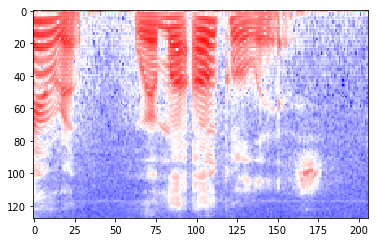

In [55]:
plt.imshow(snippet,cmap='bwr',clim=absmax(snippet))
plt.show()

In [27]:
averages = list()
n_samples = np.repeat(0,len(joint_list))
for i in range(len(layer_ranges)-1):
    contents = {'acts': np.zeros((len(joint_list),n_channels[i],layer_ranges[i])),
                'grads': np.zeros((len(joint_list),n_channels[i],layer_ranges[i]))}
    averages.append(contents)

t_start = time.time()
for f_id, f in enumerate(input_groupmappings[:1]):
    print("ok")
    spectrogram = np.load(input_dir + f[:-17] + ".npy")
    index = int((spectrogram.shape[1]-206)/2) -1
    if os.path.isfile(grad_dir+f[:-17]+"_grads_pos"+str(index).zfill(4)+".pkl"):
        groupmapping = np.load(input_dir + f)
        gm_index = 0

        with open(act_dir+f[:-17]+"_act.pkl", "rb") as input_file:
            forward_act = pickle.load(input_file)

        # go through all positions
        for index in groupmapping[:-1,0]:
#         for index in range(int((spectrogram.shape[1]-206)/2)):
            snippet = spectrogram[:,index*2:index*2+206]
            snippet_act = copy.deepcopy(forward_act)
            for i in range(len(forward_act)):
                snippet_act[i] = np.transpose(forward_act[i][0,index:index+layer_ranges[i+1],:])
            
            with open(grad_dir+f[:-17]+"_grads_pos"+str(index).zfill(4)+".pkl", "rb") as input_file:
                grads = pickle.load(input_file)
                for i in range(len(grads)):
                    grads[i] = np.abs(np.transpose(grads[i]))
                
            #ALIGNMENT
            for i in [2]:#range(len(grads)-2):
                frame_width = grads[i].shape[1]
                
                to_align_on = np.abs(grads[i])
                # option: weight abs gradients by activation strength
                # rationale -> align on high activations, which are important for the predicted letter
                #              only for activations, makes no sense for input (high input value != strong activation)
                if(i>0):
                    to_align_on = to_align_on * snippet_act[i-1]                
                
                # find time step of highest absolute gradient 
                center_index = np.argmax(np.max(to_align_on,0))
                
                
                shift = int(center_index - (frame_width/2))
                if(shift<0):
                    idx_from, idx_to = [0,frame_width+2*shift]
                elif(shift>0):
                    idx_from, idx_to = [2*shift,frame_width]
                else:
                    idx_from, idx_to = [0,frame_width]
                shift = np.abs(shift)
                
                if(i==0):
                    #align input
                    centered_frame = snippet[:,idx_from:idx_to]
#                     snippet = np.zeros_like(snippet)
#                     snippet[:,shift:snippet.shape[1]-shift] = centered_frame
                else:
                    #align activations
                    centered_frame = snippet_act[i-1][:,idx_from:idx_to]
                    snippet_act[i-1] = np.zeros_like(snippet_act[i-1])
                    snippet_act[i-1][:,shift:snippet_act[i-1].shape[1]-shift] = centered_frame
                    
                # align gradients
                centered_frame = grads[i][:,idx_from:idx_to]
#                 grads[i] = np.zeros_like(grads[i])
#                 grads[i][:,shift:grads[i].shape[1]-shift] = centered_frame
                break
            break
            
                    
            
    
    if((f_id+1) % 50==0):
        print("finished " + str(f_id+1), end=" - ")
        elapsed_time(t_start,"min")
        
# with open(data_dir + 'summation_abs_actxgrad_all_noblank.pkl', 'wb') as f:


ok


In [37]:
figure_dir = "/project/asr_introspection/figures/"
fig_format = "pdf"
cmap = mpl.colors.LinearSegmentedColormap.from_list("whitered", [(1,1,1),(1,0,0)] , N=100)
fig = plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.imshow(snippet_act[0][::-1,:],cmap=cmap)
# plt.clim(absmax(snippet))
plt.subplot(2,1,2)
plt.imshow(grads[1][::-1,:],cmap=cmap)
# plt.clim([0,np.max(grads[0])])
# plt.show()
plt.savefig(figure_dir + "single_plots_act."+fig_format,
            dpi=300,
            format=fig_format,
            bbox_inches='tight')
plt.close()

In [18]:
grads[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)